## フレクトのクラウドブログ「あいまい検索の実装を比較する - ハイブリッド検索 vs LLM」

| 段階 | Hue (°) | RGB (0–255)   | 英語表現 (Web / UI) | 日本語表現    |
| -- | ------: | ------------- | --------------- | -------- |
| 0  |      0° | (255, 0, 0)   | Red             | 赤        |
| 1  |      6° | (255, 26, 0)  | Deep Red        | 濃い赤      |
| 2  |     12° | (255, 51, 0)  | Red-Orange      | 赤寄りオレンジ  |
| 3  |     18° | (255, 77, 0)  | Orange-Red      | オレンジ寄り赤  |
| 4  |     24° | (255, 102, 0) | Orange          | オレンジ     |
| 5  |     30° | (255, 128, 0) | Mid Orange      | 中間的オレンジ  |
| 6  |     36° | (255, 153, 0) | Yellow-Orange   | 黄寄りオレンジ  |
| 7  |     42° | (255, 179, 0) | Light Orange    | 明るいオレンジ  |
| 8  |     48° | (255, 204, 0) | Orange-Yellow   | オレンジ寄り黄色 |
| 9  |     54° | (255, 230, 0) | Pale Yellow     | 淡い黄色     |
| 10 |     60° | (255, 255, 0) | Yellow          | 黄色       |

In [3]:
import pandas as pd
# 1. Parse the markdown table from the last cell
markdown_table = """| 段階 | Hue (°) | RGB (0–255)   | 英語表現 (Web / UI) | 日本語表現    |
| -- | ------: | ------------- | --------------- | -------- |
| 0  |      0° | (255, 0, 0)   | Red             | 赤        |
| 1  |      6° | (255, 26, 0)  | Deep Red        | 濃い赤      |
| 2  |     12° | (255, 51, 0)  | Red-Orange      | 赤寄りオレンジ  |
| 3  |     18° | (255, 77, 0)  | Orange-Red      | オレンジ寄り赤  |
| 4  |     24° | (255, 102, 0) | Orange          | オレンジ     |
| 5  |     30° | (255, 128, 0) | Mid Orange      | 中間的オレンジ  |
| 6  |     36° | (255, 153, 0) | Yellow-Orange   | 黄寄りオレンジ  |
| 7  |     42° | (255, 179, 0) | Light Orange    | 明るいオレンジ  |
| 8  |     48° | (255, 204, 0) | Orange-Yellow   | オレンジ寄り黄色 |
| 9  |     54° | (255, 230, 0) | Pale Yellow     | 淡い黄色     |
| 10 |     60° | (255, 255, 0) | Yellow          | 黄色       |"""

# Parse markdown table to dataframe
lines = [l.strip() for l in markdown_table.strip().split('\n') if l.strip() and not l.strip().startswith('| --')]
header = [h.strip() for h in lines[0].split('|')[1:-1]]
data = []
for line in lines[1:]:
    row = [cell.strip() for cell in line.split('|')[1:-1]]
    data.append(row)

df = pd.DataFrame(data, columns=header)
df['段階'] = df['段階'].astype(int)

# Parse RGB values
def parse_rgb(rgb_str):
    rgb_str = rgb_str.replace('(', '').replace(')', '')
    return tuple(map(int, rgb_str.split(',')))

df['RGB_tuple'] = df['RGB (0–255)'].apply(parse_rgb)

FONT_FACE = 'Hiragino Sans'
# FONT_FACE = 'Noto Sans CJK JP'

BM25 Scores (normalized):
Expression   |      Red |   Yellow
-----------------------------------
赤            |   1.0000 |   0.0000
濃い赤          |   0.0000 |   0.0000
赤寄りオレンジ      |   0.0000 |   0.0000
オレンジ寄り赤      |   0.0000 |   0.0000
オレンジ         |   0.0000 |   0.0000
中間的オレンジ      |   0.0000 |   0.0000
黄寄りオレンジ      |   0.0000 |   0.0000
明るいオレンジ      |   0.0000 |   0.0000
オレンジ寄り黄色     |   0.0000 |   0.0000
淡い黄色         |   0.0000 |   0.0000
黄色           |   0.0000 |   1.0000



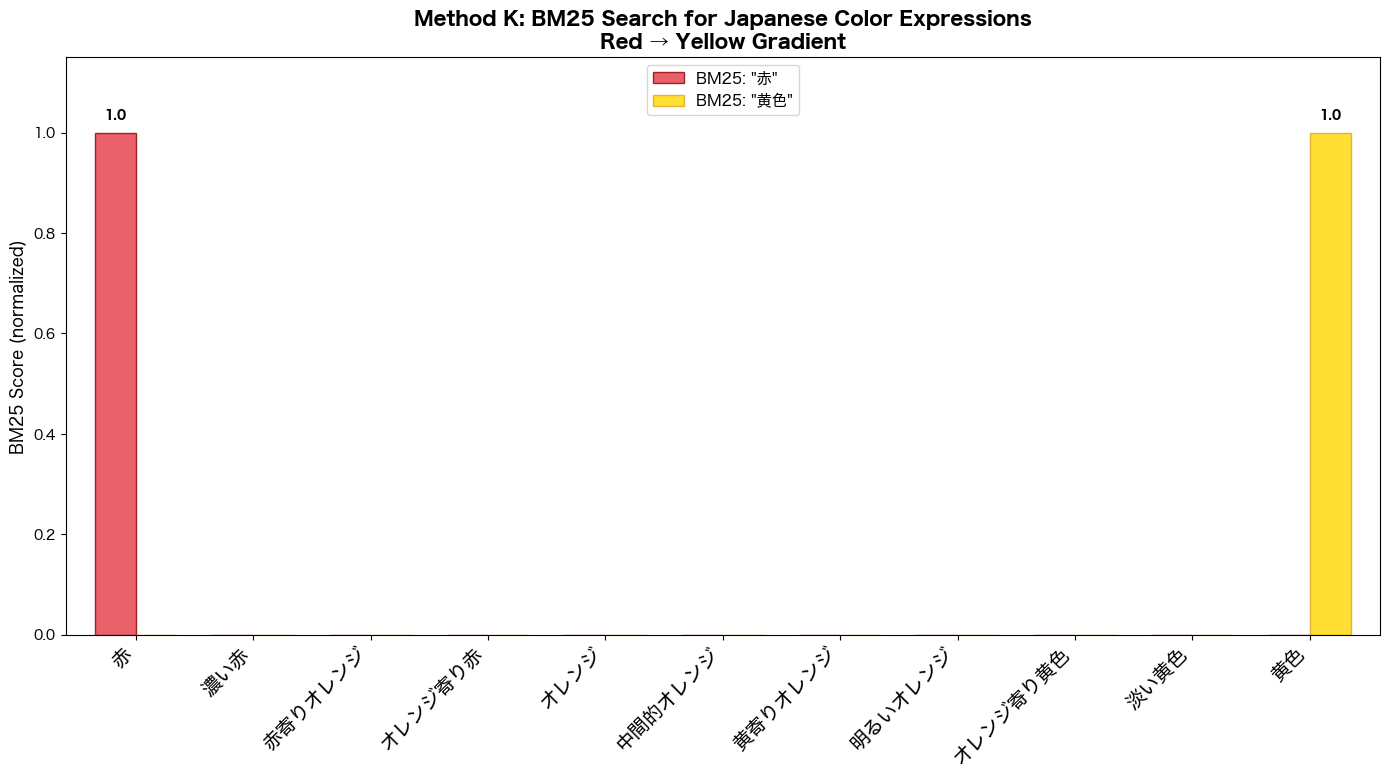

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from rank_bm25 import BM25Okapi

# Use Japanese font on macOS
plt.rcParams['font.family'] = FONT_FACE

# 2. BM25 search (no tokenization - each expression is a single token)
japanese_expressions = df['日本語表現'].tolist()
corpus = [[expr] for expr in japanese_expressions]  # Each expression as single token
bm25 = BM25Okapi(corpus)

# Search queries
red_query = ["赤"]
yellow_query = ["黄色"]
# red_query = ["赤 以外"]
# yellow_query = ["黄色 以外"]

red_scores = bm25.get_scores(red_query)
yellow_scores = bm25.get_scores(yellow_query)

# Normalize scores (max to 1.0)
red_scores_norm = red_scores / red_scores.max() if red_scores.max() > 0 else red_scores
yellow_scores_norm = yellow_scores / yellow_scores.max() if yellow_scores.max() > 0 else yellow_scores

# Print raw scores
print("BM25 Scores (normalized):")
print(f"{'Expression':<12} | {'Red':>8} | {'Yellow':>8}")
print("-" * 35)
for i, expr in enumerate(japanese_expressions):
    print(f"{expr:<12} | {red_scores_norm[i]:>8.4f} | {yellow_scores_norm[i]:>8.4f}")
print()

# 3. Create the plot
fig, ax = plt.subplots(figsize=(14, 8))

n_colors = len(df)
x_positions = np.arange(n_colors)
bar_width = 0.35

# Bar plots for BM25 scores
bars_red = ax.bar(x_positions - bar_width/2, red_scores_norm, bar_width, 
                   label='BM25: "赤"', color='#E63946', alpha=0.8, edgecolor='darkred')
bars_yellow = ax.bar(x_positions + bar_width/2, yellow_scores_norm, bar_width, 
                      label='BM25: "黄色"', color='#FFD700', alpha=0.8, edgecolor='goldenrod')

# Styling
ax.set_xlim(-0.6, n_colors - 0.4)
ax.set_ylim(0, 1.15)
ax.set_xticks(x_positions)
ax.set_xticklabels(japanese_expressions, rotation=45, ha='right', fontsize=14)
ax.set_ylabel('BM25 Score (normalized)', fontsize=12)
ax.set_title('Method K: BM25 Search for Japanese Color Expressions\nRed → Yellow Gradient', 
             fontsize=14, fontweight='bold')
ax.legend(loc='upper center', fontsize=11)
ax.axhline(y=0, color='gray', linestyle='-', linewidth=0.5)

# Add score annotations on bars
for bar, score in zip(bars_red, red_scores_norm):
    if score > 0:
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
                f'{score:.1f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

for bar, score in zip(bars_yellow, yellow_scores_norm):
    if score > 0:
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
                f'{score:.1f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.subplots_adjust(bottom=0.2)
plt.show()

Loading Multilingual E5 Large model...
Model loaded!
Generating embeddings for color expressions...
Embeddings generated!

Cosine Similarities (adjusted: -0.8, normalized):
Expression   |      Red |   Yellow
---------------------------------------------
赤            |   1.0000 |   0.4863
濃い赤          |   0.5264 |   0.2398
赤寄りオレンジ      |   0.3537 |   0.1445
オレンジ寄り赤      |   0.3606 |   0.1805
オレンジ         |   0.3276 |   0.3111
中間的オレンジ      |   0.1065 |   0.1590
黄寄りオレンジ      |   0.1415 |   0.2735
明るいオレンジ      |   0.0552 |   0.0324
オレンジ寄り黄色     |   0.1776 |   0.4531
淡い黄色         |   0.2284 |   0.6495
黄色           |   0.4863 |   1.0000


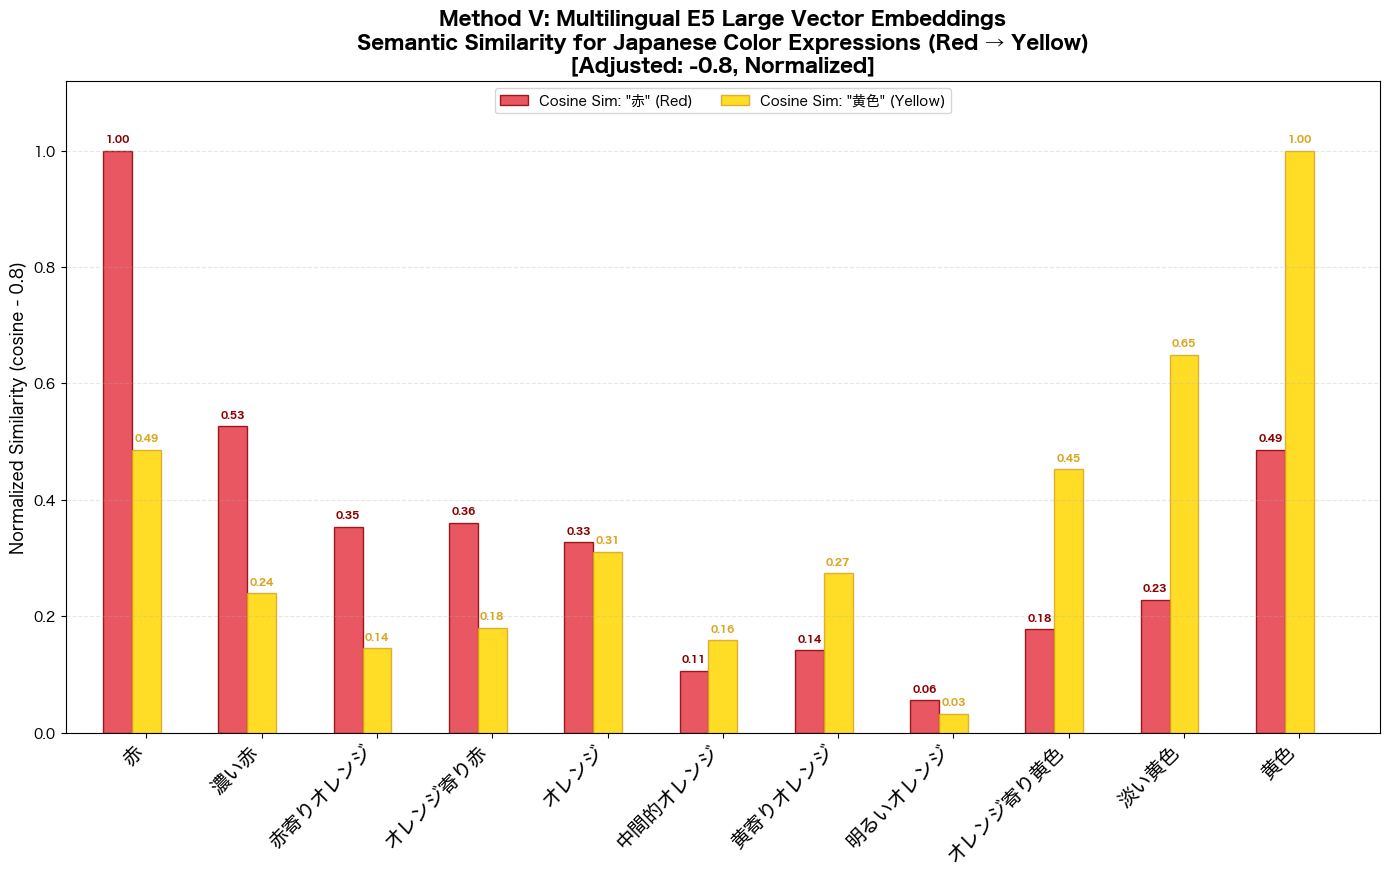

In [11]:
# Method V: Multilingual E5 Large Vector Embeddings for Japanese Color Expressions
# Using semantic embeddings to capture meaning similarity

from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import matplotlib.pyplot as plt

# Use Japanese font on macOS
plt.rcParams['font.family'] = FONT_FACE

# Load Multilingual E5 Large model
print("Loading Multilingual E5 Large model...")
model = SentenceTransformer('intfloat/multilingual-e5-large')
print("Model loaded!")

# Reuse the same dataset from the previous cell
japanese_expressions = df['日本語表現'].tolist()
colors_rgb = [tuple(c/255 for c in rgb) for rgb in df['RGB_tuple']]

# E5 models require "query: " or "passage: " prefix for optimal performance
# For similarity tasks, we use "query: " prefix
texts_to_embed = [f"query: {expr}" for expr in japanese_expressions]
red_query = "query: 赤"
yellow_query = "query: 黄色"
# red_query = "query: 赤 以外"
# yellow_query = "query: 黄色 以外"

# Generate embeddings
print("Generating embeddings for color expressions...")
color_embeddings = model.encode(texts_to_embed, normalize_embeddings=True)
red_embedding = model.encode([red_query], normalize_embeddings=True)
yellow_embedding = model.encode([yellow_query], normalize_embeddings=True)
print("Embeddings generated!")

# Calculate cosine similarities
red_similarities_raw = cosine_similarity(color_embeddings, red_embedding).flatten()
yellow_similarities_raw = cosine_similarity(color_embeddings, yellow_embedding).flatten()

# Subtract 0.8 and normalize to 0-1 range
offset = 0.8
red_adjusted = red_similarities_raw - offset
yellow_adjusted = yellow_similarities_raw - offset

# Normalize: scale so max becomes 1.0 and min becomes 0.0
def normalize(arr):
    arr_clipped = np.clip(arr, 0, None)  # Clip negative values to 0
    if arr_clipped.max() > 0:
        return arr_clipped / arr_clipped.max()
    return arr_clipped

red_similarities = normalize(red_adjusted)
yellow_similarities = normalize(yellow_adjusted)

print("\nCosine Similarities (adjusted: -0.8, normalized):")
print(f"{'Expression':<12} | {'Red':>8} | {'Yellow':>8}")
print("-" * 45)
for i, expr in enumerate(japanese_expressions):
    print(f"{expr:<12} | {red_similarities[i]:>8.4f} | {yellow_similarities[i]:>8.4f}")

# Create the visualization
fig, ax = plt.subplots(figsize=(14, 9))

n_colors = len(df)
x_positions = np.arange(n_colors)
bar_width = 0.25

# Bar plots for cosine similarities
bars_red = ax.bar(x_positions - bar_width, red_similarities, bar_width, 
                   label='Cosine Sim: "赤" (Red)', color='#E63946', alpha=0.85, edgecolor='darkred')
bars_yellow = ax.bar(x_positions, yellow_similarities, bar_width, 
                      label='Cosine Sim: "黄色" (Yellow)', color='#FFD700', alpha=0.85, edgecolor='goldenrod')

# Styling
ax.set_xlim(-0.7, n_colors - 0.3)
ax.set_ylim(0, 1.12)
ax.set_xticks(x_positions)
ax.set_xticklabels(japanese_expressions, rotation=45, ha='right', fontsize=14)
ax.set_ylabel('Normalized Similarity (cosine - 0.8)', fontsize=12)
ax.set_title('Method V: Multilingual E5 Large Vector Embeddings\nSemantic Similarity for Japanese Color Expressions (Red → Yellow)\n[Adjusted: -0.8, Normalized]', 
             fontsize=14, fontweight='bold')
ax.legend(loc='upper center', fontsize=10, ncol=3, bbox_to_anchor=(0.5, 1.0))
ax.axhline(y=0, color='gray', linestyle='-', linewidth=0.5)

# Add grid for readability
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Add score annotations on bars (only for Red and Yellow to avoid clutter)
for bar, score in zip(bars_red, red_similarities):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
            f'{score:.2f}', ha='center', va='bottom', fontsize=7, fontweight='bold', color='darkred')

for bar, score in zip(bars_yellow, yellow_similarities):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
            f'{score:.2f}', ha='center', va='bottom', fontsize=7, fontweight='bold', color='goldenrod')

plt.tight_layout()
plt.subplots_adjust(bottom=0.18)
plt.show()

Asking LLM for color decisions...

| 色表現 | LLM判定 |
|--------|---------|
| 赤 | 赤 |
| 濃い赤 | 赤 |
| 赤寄りオレンジ | 赤 |
| オレンジ寄り赤 | 赤 |
| オレンジ | 赤 |
| 中間的オレンジ | 赤 |
| 黄寄りオレンジ | 黄色 |
| 明るいオレンジ | 赤 |
| オレンジ寄り黄色 | 黄色 |
| 淡い黄色 | 黄色 |
| 黄色 | 黄色 |

LLM Decisions Summary:
  Red: 7 / 11
  Yellow: 4 / 11


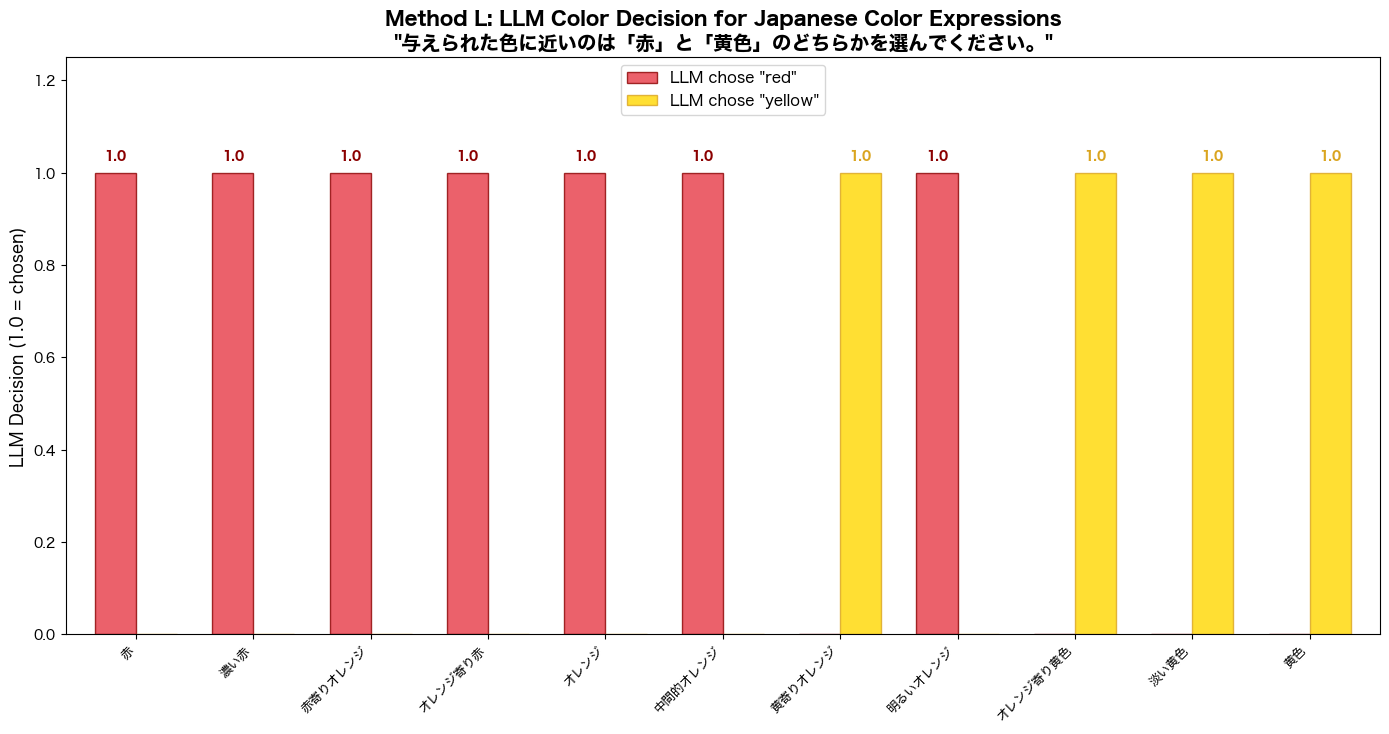

In [ ]:
# Method L: LLM-based Color Decision for Japanese Color Expressions
# Using Gemini LLM to decide if each color expression is closer to red or yellow

import os
import numpy as np
import matplotlib.pyplot as plt
from google import genai
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

# Use Japanese font
plt.rcParams['font.family'] = FONT_FACE

# LLM Configuration (loaded from environment variables)
GCLOUD_KEY_PATH = os.getenv("GCLOUD_KEY_PATH")
PROJECT_ID = os.getenv("PROJECT_ID")
LOCATION = os.getenv("LOCATION")
MODEL = "gemini-2.5-flash-lite"
# MODEL = "gemini-2.5-flash"
# MODEL = "gemini-2.5-pro"

# Set up credentials
script_dir = os.getcwd()
gcloud_key_full_path = os.path.join(script_dir, GCLOUD_KEY_PATH)
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = gcloud_key_full_path

# Initialize client
client = genai.Client(
    vertexai=True,
    project=PROJECT_ID,
    location=LOCATION
)

# LLM question
LLM_QUESTION = "与えられた色に近いのは「赤」と「黄色」のどちらかを選んでください。"

def ask_llm_color_decision(color_expression: str) -> str:
    """
    Ask LLM to decide if the given color expression is closer to red or yellow.
    Returns 'red' or 'yellow'.
    """
    prompt = f"""{LLM_QUESTION}

与えられた色: {color_expression}

一言だけで答えてください: 「赤」または「黄色」。"""
    
    response = client.models.generate_content(
        model=MODEL,
        contents=prompt,
        config={
            "temperature": 0,
            "top_p": 1,
            "top_k": 1
        }
    )
    
    answer = response.text.strip().lower()
    
    # Parse the answer
    if '赤' in answer:
        return 'red'
    elif '黄色' in answer:
        return 'yellow'
    else:
        print(f"  Warning: Unexpected answer '{answer}' for '{color_expression}', defaulting to 'red'")
        return 'red'

# Get color expressions from dataframe
japanese_expressions = df['日本語表現'].tolist()
colors_rgb = [tuple(c/255 for c in rgb) for rgb in df['RGB_tuple']]

# Ask LLM for each color expression
print("Asking LLM for color decisions...")
llm_decisions = []
for i, expr in enumerate(japanese_expressions):
    # expr = expr + ' 以外'
    decision = ask_llm_color_decision(expr)
    llm_decisions.append(decision)

# Output as markdown table
print("\n| 色表現 | LLM判定 |")
print("|--------|---------|")
for expr, decision in zip(japanese_expressions, llm_decisions):
    decision_jp = "赤" if decision == "red" else "黄色"
    print(f"| {expr} | {decision_jp} |")

# Convert decisions to scores
red_scores = np.array([1.0 if d == 'red' else 0.0 for d in llm_decisions])
yellow_scores = np.array([1.0 if d == 'yellow' else 0.0 for d in llm_decisions])

print("\nLLM Decisions Summary:")
print(f"  Red: {int(red_scores.sum())} / {len(llm_decisions)}")
print(f"  Yellow: {int(yellow_scores.sum())} / {len(llm_decisions)}")

# Create the visualization
fig, ax = plt.subplots(figsize=(14, 8))

n_colors = len(df)
x_positions = np.arange(n_colors)
bar_width = 0.35

# Bar plots for LLM decisions
bars_red = ax.bar(x_positions - bar_width/2, red_scores, bar_width, 
                   label='LLM chose "red"', color='#E63946', alpha=0.8, edgecolor='darkred')
bars_yellow = ax.bar(x_positions + bar_width/2, yellow_scores, bar_width, 
                      label='LLM chose "yellow"', color='#FFD700', alpha=0.8, edgecolor='goldenrod')

# Styling
ax.set_xlim(-0.6, n_colors - 0.4)
ax.set_ylim(0, 1.25)
ax.set_xticks(x_positions)
ax.set_xticklabels(japanese_expressions, rotation=45, ha='right', fontsize=14)
ax.set_ylabel('LLM Decision (1.0 = chosen)', fontsize=12)

# Title with LLM question at the top
ax.set_title(f'Method L: LLM Color Decision for Japanese Color Expressions\n"{LLM_QUESTION}"', 
             fontsize=14, fontweight='bold')

ax.legend(loc='upper center', fontsize=11)
ax.axhline(y=0, color='gray', linestyle='-', linewidth=0.5)

# Add decision annotations on bars
for bar, score, decision in zip(bars_red, red_scores, llm_decisions):
    if score > 0:
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
                '1.0', ha='center', va='bottom', fontsize=9, fontweight='bold', color='darkred')

for bar, score, decision in zip(bars_yellow, yellow_scores, llm_decisions):
    if score > 0:
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
                '1.0', ha='center', va='bottom', fontsize=9, fontweight='bold', color='goldenrod')

plt.tight_layout()
plt.subplots_adjust(bottom=0.2)
plt.show()
